In [ ]:
# !pip install scikit-learn pandas numpy matplotlib seaborn joblib --quiet

import os, re, html, json, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Tuple

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ModuleNotFoundError: No module named 'pandas'

In [1]:
import pandas as pd
df = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')

# --- Inspección rápida de columnas disponibles ---
print("Columnas del CSV:", list(df.columns))

Columnas del CSV: ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']


In [2]:
# --- Auto-detección de columnas: texto, label y agrupador ---
def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = set(df.columns)

# Candidatas para TEXTO
text_col = pick_first(cols, [
    "review_clean","review","review_text","review_content","content","text","critic_review"
])

# Candidatas para LABEL (binaria)
label_col = pick_first(cols, [
    "sentimiento","fresh","label","freshness","review_type","target","y"
])

# Candidatas para AGRUPADOR (película)
group_col = pick_first(cols, [
    "rotten_tomatoes_link","movie_title","title","movie","film"
])

if text_col is None:
    raise ValueError("No se encontró una columna de texto. Agrega una de: "
                     "'review_clean','review','review_text','review_content','content','text'.")

if label_col is None:
    raise ValueError("No se encontró una columna de etiqueta. Agrega una de: "
                     "'sentimiento','fresh','label','freshness','review_type','target','y'.")

if group_col is None:
    # Fallback: usa el título si existe, si no, crea grupos por índice (menos ideal)
    group_col = pick_first(cols, ["movie_title","title"])
    if group_col is None:
        print("⚠️ No hay columna de agrupación (película). Se usará índice como grupo (no ideal).")
        df["_group_fallback"] = (df.index // 10)  # agrupa por bloques de 10 para no dejar todo separado
        group_col = "_group_fallback"

# --- Limpieza mínima del texto (similar a lo sugerido) ---
import re, html
TAG_RE = re.compile(r"<[^>]+>")
WS_RE  = re.compile(r"\s+")
def clean_text(t: str) -> str:
    if not isinstance(t, str): return ""
    t = html.unescape(t)
    t = TAG_RE.sub(" ", t)
    t = re.sub(r"n['’]t\b", " not", t)  # don’t -> do not (mejora polaridad)
    t = WS_RE.sub(" ", t).strip()
    return t

# --- Construye columnas estándar que usará el pipeline ---
df = df.copy()
df["review_clean"] = df[text_col].map(clean_text)

# Normaliza la etiqueta a 0/1 en 'sentimiento'
def to_binary_label(v):
    if pd.isna(v): return None
    # texto
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"fresh","positivo","positive","pos","freshness_fresh","freshness fresh"}:
            return 1
        if s in {"rotten","negativo","negative","neg","freshness_rotten","freshness rotten"}:
            return 0
        # a veces vienen "Fresh"/"Rotten" con mayúscula
        if "fresh" in s:  return 1
        if "rotten" in s: return 0
    # numérico (0/1)
    try:
        f = float(v)
        if f in (0,1): return int(f)
        # si viniera un rating 1–5, umbraliza:
        if 0 <= f <= 1: return int(round(f))  # por si ya vino en [0,1]
        if 1 <= f <= 5: return int(f >= 3)    # simple: >=3 positivo
    except Exception:
        pass
    return None

df["sentimiento"] = df[label_col].apply(to_binary_label)

# Filtra nulos y prepara trio (texto, label, grupo)
df = df[["review_clean","sentimiento",group_col]].dropna(subset=["review_clean","sentimiento"])
df.rename(columns={group_col: "group_key"}, inplace=True)

print(df[["review_clean","sentimiento","group_key"]].head())
print(df.isna().sum())



                                        review_clean  sentimiento  group_key
0  A fantasy adventure that fuses Greek mythology...            1  m/0814255
1  Uma Thurman as Medusa, the gorgon with a coiff...            1  m/0814255
2  With a top-notch cast and dazzling special eff...            1  m/0814255
3  Whether audiences will get behind The Lightnin...            1  m/0814255
4  What's really lacking in The Lightning Thief i...            0  m/0814255
review_clean    0
sentimiento     0
group_key       0
dtype: int64


In [3]:
from sklearn.model_selection import GroupShuffleSplit

X = df["review_clean"]
y = df["sentimiento"].astype(int)
groups = df["group_key"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


Columnas del CSV: ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']
                                    review_clean_std  sentimiento_std  \
0  A fantasy adventure that fuses Greek mythology...                1   
1  Uma Thurman as Medusa, the gorgon with a coiff...                1   
2  With a top-notch cast and dazzling special eff...                1   
3  Whether audiences will get behind The Lightnin...                1   
4  What's really lacking in The Lightning Thief i...                0   

   group_key  
0  m/0814255  
1  m/0814255  
2  m/0814255  
3  m/0814255  
4  m/0814255  
Train: 908582  |  Test: 221435

Accuracy: 0.8080 | Precision: 0.8954 | Recall: 0.7933 | F1: 0.8412

Classification Report:
               precision    recall  f1-score   support

           0     0.6932    0.8344    0.7573     79461
           1     0.8954    0.7933    0.8412    141974

    accuracy                 

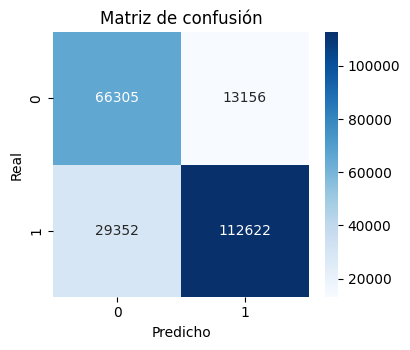

ROC-AUC: 0.9007


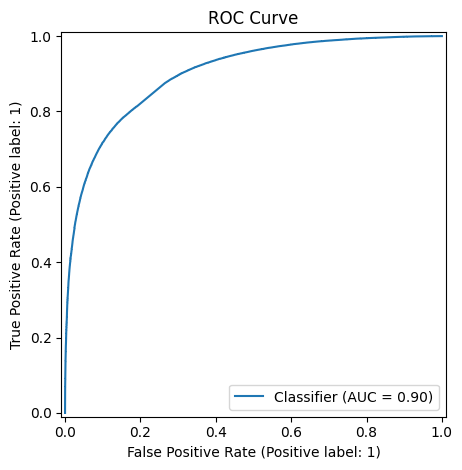

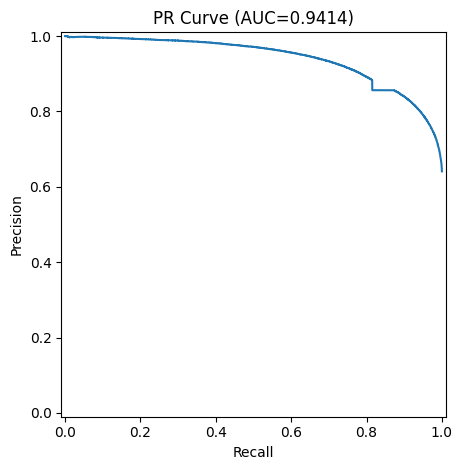


✅ Exportado en: C:\Users\fabri\Desktop\Portfolio\Rotten tomatoes\rotten-tomatoes-critics-nlp\export_tfidf_lr_windows


C:\Users\fabri\AppData\Local\Temp\ipykernel_34344\3861599817.py:63: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().isoformat() + "Z"


In [6]:
# ============================
# ENTRENAMIENTO TF-IDF + LR (Windows-safe)
# ============================
# Requisitos:
# pip install scikit-learn pandas numpy joblib seaborn matplotlib

import os, re, html, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- utilidades ----------
def clean_text(t: str) -> str:
    """Limpieza segura: des-escapa entidades, quita tags, preserva negaciones."""
    if not isinstance(t, str):
        return ""
    t = html.unescape(t)
    t = re.sub(r"<[^>]+>", " ", t)          # elimina HTML
    t = re.sub(r"n['’]t\b", " not", t)      # don't -> do not (polaridad)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def binarize_label(v):
    """Convierte Fresh/Rotten o números a 0/1."""
    if pd.isna(v):
        return None
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"fresh","positivo","positive","pos","freshness_fresh","freshness fresh"}:
            return 1
        if s in {"rotten","negativo","negative","neg","freshness_rotten","freshness rotten"}:
            return 0
        if "fresh" in s:  return 1
        if "rotten" in s: return 0
    try:
        f = float(v)
        if f in (0,1): return int(f)
        if 0 <= f <= 1: return int(round(f))
        if 1 <= f <= 5: return int(f >= 3)
    except Exception:
        pass
    return None

def fecha_utc():
    return datetime.utcnow().isoformat() + "Z"

# =============== PROGRAMA PRINCIPAL ===============
if __name__ == "__main__":
    # --- 1) Carga de datos ---
    # Cambia la ruta si corresponde
    df = pd.read_csv("data/rotten_tomatoes_critic_reviews.csv")
    print("Columnas del CSV:", list(df.columns))

    cols = set(df.columns)

    text_col = pick_first(cols, ["review_clean","review","review_text","review_content","content","text","critic_review"])
    label_col = pick_first(cols, ["sentimiento","fresh","label","freshness","review_type","target","y"])
    group_col = pick_first(cols, ["rotten_tomatoes_link","movie_title","title","movie","film"])

    if text_col is None:
        raise ValueError("No se encontró columna de texto (ej: review_clean, review, content, text).")
    if label_col is None:
        raise ValueError("No se encontró columna de etiqueta (ej: sentimiento, fresh, label).")

    # Fallback para agrupación
    if group_col is None:
        print("⚠️  No hay columna de agrupación (película). Se usará bloque por índice.")
        df["_group_key"] = (df.index // 10)  # agrupa en bloques de 10
        group_col = "_group_key"

    # --- 2) Normalización de columnas estándar ---
    df = df.copy()
    df["review_clean_std"] = df[text_col].map(clean_text)
    df["sentimiento_std"] = df[label_col].apply(binarize_label)
    df["group_key"]       = df[group_col]

    df = df[["review_clean_std","sentimiento_std","group_key"]].dropna(subset=["review_clean_std","sentimiento_std"])
    df["sentimiento_std"] = df["sentimiento_std"].astype(int)

    print(df.head())

    # --- 3) Split por grupo (película) ---
    X_all = df["review_clean_std"]
    y_all = df["sentimiento_std"]
    groups = df["group_key"]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X_all, y_all, groups))

    X_train, X_test = X_all.iloc[train_idx],  X_all.iloc[test_idx]
    y_train, y_test = y_all.iloc[train_idx],  y_all.iloc[test_idx]
    groups_train = groups.iloc[train_idx]

    print(f"Train: {len(X_train)}  |  Test: {len(X_test)}")

    # --- 4) Pipeline TF-IDF + LR (Windows-safe: n_jobs=1) ---
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            max_features=100_000,   # ajusta según RAM
            min_df=3,
            max_df=0.9,
            sublinear_tf=True,
            lowercase=True,
            norm="l2"
        )),
        ("clf", LogisticRegression(
            solver="liblinear",      # permite l1/l2, robusto
            penalty="l2",            # puedes probar "l1"
            C=2.0,                   # buen punto de partida
            class_weight="balanced", # si hay desbalance
            random_state=RANDOM_STATE,
            max_iter=400,
            n_jobs=1                 # <- evita _posixsubprocess en Windows
        ))
    ])

    # (Opcional) Validación cruzada por grupo con pocos valores de C/penalty:
    # Para evitar heavy parallel en Windows, mantenemos n_jobs=1.
    # from sklearn.model_selection import GridSearchCV
    # gkf = GroupKFold(n_splits=5)
    # grid = {"clf__C":[0.5,1.0,2.0,4.0], "clf__penalty":["l2","l1"]}
    # gs = GridSearchCV(pipe, grid, scoring="f1", cv=gkf.split(X_train,y_train,groups_train), n_jobs=1, verbose=1)
    # gs.fit(X_train, y_train)
    # model = gs.best_estimator_
    # print("Mejores params:", gs.best_params_)

    # Entrenamiento directo (rápido) para Windows
    model = pipe.fit(X_train, y_train)

    # --- 5) Evaluación ---
    y_pred  = model.predict(X_test)
    has_proba = hasattr(model.named_steps["clf"], "predict_proba")
    y_proba = model.predict_proba(X_test)[:,1] if has_proba else None

    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print(f"\nAccuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de confusión")
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

    # Curvas ROC / PR si hay probabilidades
    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {roc:.4f}")

        from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title("ROC Curve"); plt.tight_layout(); plt.show()

        pr, rc, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(rc, pr)
        PrecisionRecallDisplay(precision=pr, recall=rc).plot()
        plt.title(f"PR Curve (AUC={pr_auc:.4f})"); plt.tight_layout(); plt.show()

    # --- 6) Exportación (pipeline completo) ---
    OUTDIR = Path("export_tfidf_lr_windows")
    OUTDIR.mkdir(exist_ok=True)

    joblib.dump(model, OUTDIR / "tfidf_lr_pipeline.joblib")

    meta = {
        "created_at": fecha_utc(),
        "model": "TFIDF+LogisticRegression(liblinear)",
        "random_state": RANDOM_STATE,
        "metrics": {"accuracy": float(acc), "precision": float(p), "recall": float(r), "f1": float(f1)},
        "tfidf": {"max_features": 100_000, "ngram_range": [1,2], "min_df": 3, "max_df": 0.9, "sublinear_tf": True},
        "clf": {"C": 2.0, "penalty": "l2", "class_weight": "balanced", "max_iter": 400},
        "group_split": True
    }
    with open(OUTDIR / "model_card.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"\n✅ Exportado en: {OUTDIR.resolve()}")



Columnas del CSV: ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']


[I 2025-08-20 17:44:47,393] A new study created in memory with name: no-name-df23fe64-2c6a-42c2-a391-43926e5e4968


Train: 908582  |  Test: 221435


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-08-20 17:47:24,134] Trial 0 finished with value: 0.7375852817001829 and parameters: {'tfidf_ngram_hi': 2, 'tfidf_max_features': 50000, 'tfidf_min_df': 10, 'tfidf_max_df': 0.8683122032880984, 'tfidf_sublinear_tf': True, 'clf_penalty': 'l1', 'clf_C': 0.018794668241638456}. Best is trial 0 with value: 0.7375852817001829.
[I 2025-08-20 17:48:25,197] Trial 1 finished with value: 0.8122845844490403 and parameters: {'tfidf_ngram_hi': 1, 'tfidf_max_features': 200000, 'tfidf_min_df': 5, 'tfidf_max_df': 0.781800501589861, 'tfidf_sublinear_tf': False, 'clf_penalty': 'l1', 'clf_C': 1.2173252504194043}. Best is trial 1 with value: 0.8122845844490403.
[I 2025-08-20 17:51:04,812] Trial 2 finished with value: 0.833873597210658 and parameters: {'tfidf_ngram_hi': 2, 'tfidf_max_features': 100000, 'tfidf_min_df': 5, 'tfidf_max_df': 0.7852918553685437, 'tfidf_sublinear_tf': False, 'clf_penalty': 'l1', 'clf_C': 0.9355380606452179}. Best is trial 2 with value: 0.833873597210658.
[I 2025-08-20 17:52:3

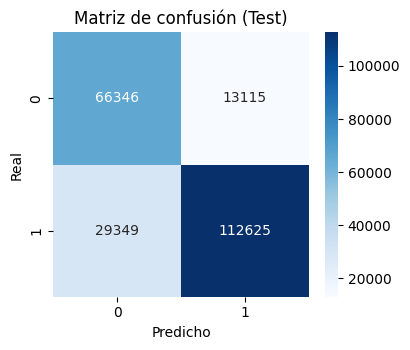

ROC-AUC: 0.9009


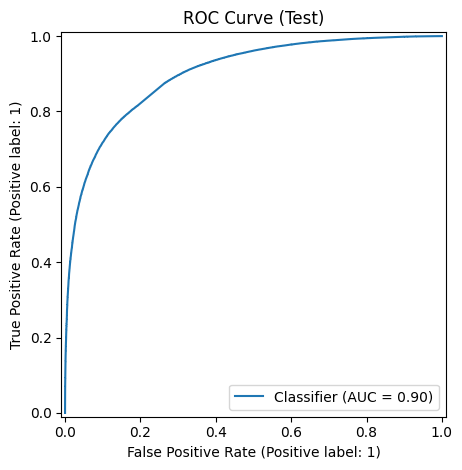

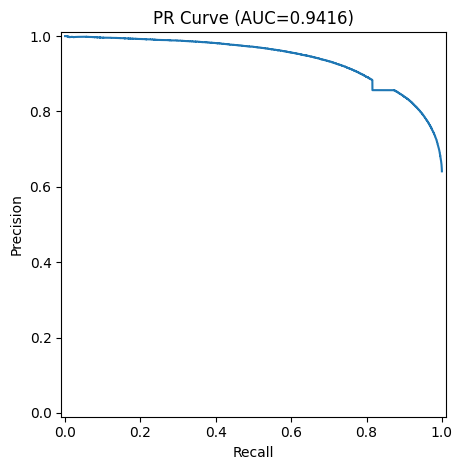


✅ Exportado en: C:\Users\fabri\Desktop\Portfolio\Rotten tomatoes\rotten-tomatoes-critics-nlp\export_optuna_tfidf_lr


C:\Users\fabri\AppData\Local\Temp\ipykernel_15980\2542520188.py:65: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().isoformat() + "Z"


In [6]:
# ============================
# OPTUNA TUNING: TF-IDF + LOGISTIC REGRESSION (Windows-safe)
# ============================
# Requisitos:
# pip install scikit-learn pandas numpy joblib seaborn matplotlib optuna

import os, re, html, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- utilidades ----------
def clean_text(t: str) -> str:
    """Limpieza segura: des-escapa entidades, quita tags, preserva negaciones."""
    if not isinstance(t, str):
        return ""
    t = html.unescape(t)
    t = re.sub(r"<[^>]+>", " ", t)          # elimina HTML
    t = re.sub(r"n['’]t\b", " not", t)      # don't -> do not (polaridad)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def binarize_label(v):
    """Convierte Fresh/Rotten o números a 0/1."""
    if pd.isna(v):
        return None
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"fresh","positivo","positive","pos","freshness_fresh","freshness fresh"}:
            return 1
        if s in {"rotten","negativo","negative","neg","freshness_rotten","freshness rotten"}:
            return 0
        if "fresh" in s:  return 1
        if "rotten" in s: return 0
    try:
        f = float(v)
        if f in (0,1): return int(f)
        if 0 <= f <= 1: return int(round(f))
        if 1 <= f <= 5: return int(f >= 3)
    except Exception:
        pass
    return None

def fecha_utc():
    return datetime.utcnow().isoformat() + "Z"

# =============== PROGRAMA PRINCIPAL ===============
if __name__ == "__main__":
    # ------------ CONFIG -------------
    CSV_PATH   = "data/rotten_tomatoes_critic_reviews.csv"  # ajusta si hace falta
    N_TRIALS   = 40                                          # puedes subir a 60-100 si quieres
    N_SPLITS   = 3                                           # GroupKFold interno para Optuna
    TEST_SIZE  = 0.20
    OUTDIR     = Path("export_optuna_tfidf_lr")
    OUTDIR.mkdir(exist_ok=True)

    # --- 1) Carga de datos ---
    df = pd.read_csv(CSV_PATH)
    print("Columnas del CSV:", list(df.columns))

    cols = set(df.columns)
    text_col  = pick_first(cols, ["review_clean","review","review_text","review_content","content","text","critic_review"])
    label_col = pick_first(cols, ["sentimiento","fresh","label","freshness","review_type","target","y"])
    group_col = pick_first(cols, ["rotten_tomatoes_link","movie_title","title","movie","film"])

    if text_col is None:
        raise ValueError("No se encontró columna de texto (ej: review_clean, review, content, text).")
    if label_col is None:
        raise ValueError("No se encontró columna de etiqueta (ej: sentimiento, fresh, label).")
    if group_col is None:
        print("⚠️  No hay columna de agrupación (película). Se usará bloque por índice.")
        df["_group_key"] = (df.index // 10)
        group_col = "_group_key"

    df = df.copy()
    df["review_clean_std"] = df[text_col].map(clean_text)
    df["sentimiento_std"]  = df[label_col].apply(binarize_label)
    df["group_key"]        = df[group_col]

    df = df[["review_clean_std","sentimiento_std","group_key"]].dropna(subset=["review_clean_std","sentimiento_std"])
    df["sentimiento_std"] = df["sentimiento_std"].astype(int)

    # --- 2) Split por grupo (película) ---
    X_all = df["review_clean_std"]
    y_all = df["sentimiento_std"]
    groups_all = df["group_key"]

    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X_all, y_all, groups_all))

    X_train, X_test = X_all.iloc[train_idx],  X_all.iloc[test_idx]
    y_train, y_test = y_all.iloc[train_idx],  y_all.iloc[test_idx]
    groups_train    = groups_all.iloc[train_idx]

    print(f"Train: {len(X_train)}  |  Test: {len(X_test)}")

    # --- 3) Definición del objetivo Optuna (F1 con GroupKFold) ---
    gkf = GroupKFold(n_splits=N_SPLITS)

    def objective(trial: optuna.Trial) -> float:
        # espacios de búsqueda (con límites “sensatos” para RAM/tiempo)
        ngram_hi     = trial.suggest_int("tfidf_ngram_hi", 1, 3)
        max_features = trial.suggest_categorical("tfidf_max_features", [50_000, 100_000, 200_000])
        min_df       = trial.suggest_categorical("tfidf_min_df", [2, 3, 5, 10])
        max_df       = trial.suggest_float("tfidf_max_df", 0.7, 0.98)
        sublinear    = trial.suggest_categorical("tfidf_sublinear_tf", [True, False])

        # penalización y solver compatibles
        penalty = trial.suggest_categorical("clf_penalty", ["l1","l2"])
        # liblinear es estable y soporta l1/l2 (binario), con predict_proba
        solver   = "liblinear"

        C = trial.suggest_float("clf_C", 1e-3, 1e+3, log=True)

        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(
                ngram_range=(1, ngram_hi),
                max_features=max_features,
                min_df=min_df,
                max_df=max_df,
                sublinear_tf=sublinear,
                lowercase=True,
                norm="l2"
            )),
            ("clf", LogisticRegression(
                solver=solver,
                penalty=penalty,
                C=C,
                class_weight="balanced",
                random_state=RANDOM_STATE,
                max_iter=400,
                n_jobs=1     # Windows-safe
            ))
        ])

        # CV por grupo
        f1s = []
        for tr_idx, va_idx in gkf.split(X_train, y_train, groups=groups_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
            pipe.fit(X_tr, y_tr)
            y_hat = pipe.predict(X_va)
            f1 = f1_score(y_va, y_hat, average="binary")
            f1s.append(f1)

        return float(np.mean(f1s))

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=RANDOM_STATE)
    )
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

    print("🏁 Mejor trial:")
    print("  value (F1):", study.best_value)
    print("  params:", study.best_params)

    # --- 4) Re-entrena con los mejores hiperparámetros en todo el train ---
    bp = study.best_params
    best_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, bp["tfidf_ngram_hi"]),
            max_features=bp["tfidf_max_features"],
            min_df=bp["tfidf_min_df"],
            max_df=bp["tfidf_max_df"],
            sublinear_tf=bp["tfidf_sublinear_tf"],
            lowercase=True,
            norm="l2"
        )),
        ("clf", LogisticRegression(
            solver="liblinear",
            penalty=bp["clf_penalty"],
            C=bp["clf_C"],
            class_weight="balanced",
            random_state=RANDOM_STATE,
            max_iter=400,
            n_jobs=1
        ))
    ])

    best_pipe.fit(X_train, y_train)

    # --- 5) Evaluación en test ---
    y_pred  = best_pipe.predict(X_test)
    has_proba = hasattr(best_pipe.named_steps["clf"], "predict_proba")
    y_proba = best_pipe.predict_proba(X_test)[:,1] if has_proba else None

    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print(f"\n📊 TEST | Accuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de confusión (Test)")
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
        print(f"ROC-AUC: {roc:.4f}")
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title("ROC Curve (Test)"); plt.tight_layout(); plt.show()
        pr, rc, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(rc, pr)
        PrecisionRecallDisplay(precision=pr, recall=rc).plot()
        plt.title(f"PR Curve (AUC={pr_auc:.4f})"); plt.tight_layout(); plt.show()

    # --- 6) Exportación ---
    joblib.dump(best_pipe, OUTDIR / "tfidf_lr_pipeline.joblib")

    meta = {
        "created_at": fecha_utc(),
        "random_state": RANDOM_STATE,
        "cv": {"type": "GroupKFold", "n_splits": int(N_SPLITS)},
        "optuna": {
            "n_trials": int(N_TRIALS),
            "best_value_f1_cv": float(study.best_value),
            "best_params": {k: (float(v) if isinstance(v, (np.floating,)) else v) for k,v in bp.items()}
        },
        "test_metrics": {
            "accuracy": float(acc), "precision": float(p), "recall": float(r), "f1": float(f1)
        }
    }
    with open(OUTDIR / "model_card.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"\n✅ Exportado en: {OUTDIR.resolve()}")


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib, numpy as np

# Usa tus splits (X_train, y_train, X_test, y_test, groups_train) ya construidos con GroupSplit.
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=100_000,
    min_df=10,
    max_df=0.8545,
    sublinear_tf=True,
    lowercase=True,
    norm="l2"
)

base = LinearSVC()  # rápido y suele elevar el margen
clf = CalibratedClassifierCV(base, method="sigmoid", cv=3)  # Platt scaling

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
# Validación por grupo breve (opcional)
gkf = GroupKFold(n_splits=3)
f1s = []
for tr_idx, va_idx in gkf.split(X_train, y_train, groups=groups_train):
    pipe.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
    preds = pipe.predict(X_train.iloc[va_idx])
    f1s.append(f1_score(y_train.iloc[va_idx], preds))
print("CV F1 (SVC+Calibrated):", np.mean(f1s))

# Entrena final y evalúa en test
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("TEST report:\n", classification_report(y_test, y_pred, digits=4))

# Probabilidades calibradas para métricas ROC/PR o UI
y_proba = pipe.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
joblib.dump(pipe, "export_calibrated_svc/tfidf_svc_calibrated.joblib")


CV F1 (SVC+Calibrated): 0.8611079698857349
TEST report:
               precision    recall  f1-score   support

           0     0.7985    0.6693    0.7282     79461
           1     0.8303    0.9055    0.8662    141974

    accuracy                         0.8207    221435
   macro avg     0.8144    0.7874    0.7972    221435
weighted avg     0.8189    0.8207    0.8167    221435

Accuracy: 0.8207103664732314


FileNotFoundError: [Errno 2] No such file or directory: 'export_calibrated_svc/tfidf_svc_calibrated.joblib'

In [8]:
import os, joblib

# Crear carpeta si no existe
os.makedirs("export_calibrated_svc", exist_ok=True)

# Guardar el pipeline calibrado
joblib.dump(pipe, "export_calibrated_svc/tfidf_svc_calibrated.joblib")
print("✅ Modelo guardado en export_calibrated_svc/tfidf_svc_calibrated.joblib")


✅ Modelo guardado en export_calibrated_svc/tfidf_svc_calibrated.joblib


[CV] C=0.5 | class_weight=None -> F1=0.8610
[CV] C=1.0 | class_weight=None -> F1=0.8586
[CV] C=2.0 | class_weight=None -> F1=0.8551
[CV] C=0.5 | class_weight=balanced -> F1=0.8610
[CV] C=1.0 | class_weight=balanced -> F1=0.8586
[CV] C=2.0 | class_weight=balanced -> F1=0.8551

🏁 Mejor (CV): 0.8610140668267249 | C: 0.5 | class_weight: None

[TEST @0.50] Acc=0.8240 | Prec=0.8342 | Rec=0.9054 | F1=0.8684

Classification Report (0.50):
               precision    recall  f1-score   support

           0     0.8006    0.6785    0.7345     79461
           1     0.8342    0.9054    0.8684    141974

    accuracy                         0.8240    221435
   macro avg     0.8174    0.7920    0.8014    221435
weighted avg     0.8221    0.8240    0.8203    221435


[TEST @0.58] Acc=0.8235 | Prec=0.8560 | Rec=0.8713 | F1_pos=0.8635 | F1_macro=0.8068

Classification Report (th óptimo):
               precision    recall  f1-score   support

           0     0.7624    0.7380    0.7500     79461
     

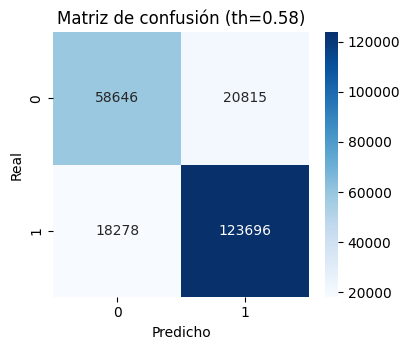


✅ Guardado en: C:\Users\fabri\Desktop\Portfolio\Rotten tomatoes\rotten-tomatoes-critics-nlp\export_calibrated_svc
   - Modelo: tfidf_svc_calibrated.joblib
   - Metadata: model_card_svc.json (incluye threshold óptimo 0.58)


In [9]:

# ============================
# MINI GRID - SVC + CALIBRATION (Windows-safe)
# ============================
# pip install scikit-learn joblib seaborn matplotlib --quiet

import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Usa los mejores hiperparámetros de TF-IDF que arrojó Optuna ---
TFIDF_KW = dict(
    ngram_range=(1, 2),
    max_features=100_000,
    min_df=10,
    max_df=0.8544978065650001,
    sublinear_tf=True,
    lowercase=True,
    norm="l2"
)

GRID_C = [0.5, 1.0, 2.0]
GRID_CLASS_WEIGHT = [None, "balanced"]
N_SPLITS = 2  # pequeño para ir rápido

def cv_score(pipe, X, y, groups, n_splits=2):
    gkf = GroupKFold(n_splits=n_splits)
    f1s = []
    for tr_idx, va_idx in gkf.split(X, y, groups=groups):
        pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        y_hat = pipe.predict(X.iloc[va_idx])
        f1s.append(f1_score(y.iloc[va_idx], y_hat, average="binary"))
    return float(np.mean(f1s))

best = {"f1_cv": -1, "C": None, "class_weight": None, "pipe": None}

for cw in GRID_CLASS_WEIGHT:
    for C in GRID_C:
        base = LinearSVC(C=C)
        clf = CalibratedClassifierCV(base, method="sigmoid", cv=3)  # Platt
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(**TFIDF_KW)),
            ("clf", clf)
        ])
        f1cv = cv_score(pipe, X_train, y_train, groups_train, n_splits=N_SPLITS)
        print(f"[CV] C={C} | class_weight={cw} -> F1={f1cv:.4f}")
        if f1cv > best["f1_cv"]:
            best.update({"f1_cv": f1cv, "C": C, "class_weight": cw, "pipe": pipe})

print("\n🏁 Mejor (CV):", best["f1_cv"], "| C:", best["C"], "| class_weight:", best["class_weight"])

# --- Re-entrena con todo el train ---
# (Volvemos a construir el pipeline con esos hiperparámetros)
final_base = LinearSVC(C=best["C"], class_weight=best["class_weight"])
final_clf  = CalibratedClassifierCV(final_base, method="sigmoid", cv=3)
final_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(**TFIDF_KW)),
    ("clf", final_clf)
])
final_pipe.fit(X_train, y_train)

# --- Eval en test (umbral 0.5) ---
proba = final_pipe.predict_proba(X_test)[:, 1]
pred_05 = (proba >= 0.5).astype(int)

acc_05 = accuracy_score(y_test, pred_05)
p_05, r_05, f1_05, _ = precision_recall_fscore_support(y_test, pred_05, average="binary")
print(f"\n[TEST @0.50] Acc={acc_05:.4f} | Prec={p_05:.4f} | Rec={r_05:.4f} | F1={f1_05:.4f}")
print("\nClassification Report (0.50):\n", classification_report(y_test, pred_05, digits=4))

# --- Buscar umbral óptimo (max F1 macro) ---
ths = np.linspace(0.30, 0.70, 41)
best_th, best_macro = 0.5, -1
for th in ths:
    preds = (proba >= th).astype(int)
    p0, r0, f10, _ = precision_recall_fscore_support(y_test, preds, average=None, labels=[0,1])
    # F1 por clase:
    f1_neg = f10[0]; f1_pos = f10[1]
    macro_f1 = (f1_neg + f1_pos)/2
    if macro_f1 > best_macro:
        best_macro, best_th = macro_f1, th

pred_opt = (proba >= best_th).astype(int)
acc_opt = accuracy_score(y_test, pred_opt)
p_opt, r_opt, f1_opt, _ = precision_recall_fscore_support(y_test, pred_opt, average="binary")
print(f"\n[TEST @{best_th:.2f}] Acc={acc_opt:.4f} | Prec={p_opt:.4f} | Rec={r_opt:.4f} | F1_pos={f1_opt:.4f} | F1_macro={best_macro:.4f}")

print("\nClassification Report (th óptimo):\n", classification_report(y_test, pred_opt, digits=4))

# --- Matriz de confusión (umbral óptimo) ---
plt.figure(figsize=(4.2,3.6))
sns.heatmap(confusion_matrix(y_test, pred_opt), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión (th={best_th:.2f})")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

# --- Guardar modelo y metadatos ---
OUTDIR = Path("export_calibrated_svc")
OUTDIR.mkdir(exist_ok=True)
joblib.dump(final_pipe, OUTDIR / "tfidf_svc_calibrated.joblib")

meta = {
    "tfidf_params": TFIDF_KW,
    "svc": {"C": best["C"], "class_weight": best["class_weight"]},
    "cv": {"n_splits": int(N_SPLITS), "f1_cv": float(best["f1_cv"])},
    "test_default_th_0.5": {"accuracy": float(acc_05), "precision_pos": float(p_05), "recall_pos": float(r_05), "f1_pos": float(f1_05)},
    "best_threshold": float(best_th),
    "test_at_best_th": {"accuracy": float(acc_opt), "precision_pos": float(p_opt), "recall_pos": float(r_opt), "f1_pos": float(f1_opt), "f1_macro": float(best_macro)}
}
with open(OUTDIR / "model_card_svc.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f"\n✅ Guardado en: {OUTDIR.resolve()}")
print(f"   - Modelo: tfidf_svc_calibrated.joblib")
print(f"   - Metadata: model_card_svc.json (incluye threshold óptimo {best_th:.2f})")


In [4]:
import os, sys, subprocess

# 1) Quita TensorFlow/keras de este entorno (ignora avisos si no estaban)
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y",
                "tensorflow", "tensorflow-intel", "tensorflow-cpu", "keras"])

# 2) Fija variables ANTES de importar transformers
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

# 3) Verifica que ya no esté TF
print("tensorflow?", subprocess.run([sys.executable, "-m", "pip", "show", "tensorflow"],
                                    capture_output=True, text=True).stdout or "NO INSTALADO")


tensorflow? NO INSTALADO


In [2]:
# CPU-only (cámbialo por CUDA si tienes GPU NVIDIA)
!{sys.executable} -m pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install -U transformers datasets accelerate evaluate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Defaulting to user installation because normal site-packages is not writeable


# Empezar aqui con Kernell .ven 3.11

In [5]:
import re, html, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# --- carga tu CSV si hace falta ---
# df = pd.read_csv("data/rotten_tomatoes_critic_reviews.csv")

def clean_text(t: str) -> str:
    if not isinstance(t, str): return ""
    t = html.unescape(t)
    t = re.sub(r"<[^>]+>", " ", t)
    t = re.sub(r"n['’]t\b", " not", t)  # don't->do not
    t = re.sub(r"\s+", " ", t).strip()
    return t

def pick_first(cols, cands):
    for c in cands:
        if c in cols: return c
    return None

def binarize_label(v):
    if pd.isna(v): return None
    if isinstance(v, str):
        s = v.strip().lower()
        if "fresh" in s or s in {"positive","pos"}:  return 1
        if "rotten" in s or s in {"negative","neg"}: return 0
    try:
        f = float(v)
        if f in (0,1): return int(f)
        if 1 <= f <= 5: return int(f >= 3)
        if 0 <= f <= 1: return int(round(f))
    except: pass
    return None

cols = set(df.columns)
text_col  = pick_first(cols, ["review_clean","review","review_text","content","text","critic_review"])
label_col = pick_first(cols, ["sentimiento","fresh","label","freshness","review_type","target","y"])
group_col = pick_first(cols, ["rotten_tomatoes_link","movie_title","title","movie","film"])

if text_col is None or label_col is None:
    raise ValueError("No encuentro columnas de texto/label. Revisa nombres en tu CSV/DF.")

if group_col is None:
    df["_group_key"] = (df.index // 10)
    group_col = "_group_key"

df_trf = pd.DataFrame({
    "text":  df[text_col].map(clean_text),
    "label": df[label_col].map(binarize_label),
    "group": df[group_col]
}).dropna()

X_all, y_all, groups_all = df_trf["text"], df_trf["label"].astype(int), df_trf["group"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups_all))

X_train, X_test = X_all.iloc[tr_idx], X_all.iloc[te_idx]
y_train, y_test = y_all.iloc[tr_idx], y_all.iloc[te_idx]
groups_train     = groups_all.iloc[tr_idx]

print(len(X_train), len(X_test))

904007 226010


In [7]:
import os, numpy as np, pandas as pd, torch, random
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Evita TensorFlow/Flax
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from transformers.training_args import TrainingArguments
from transformers.trainer_utils import IntervalStrategy
from transformers import get_cosine_schedule_with_warmup, set_seed

# ======= Config GPU / precisión =======
HAS_CUDA = torch.cuda.is_available()
if HAS_CUDA:
    print("✅ GPU detectada:", torch.cuda.get_device_name(0), "| Capability:", torch.cuda.get_device_capability(0))
    # Acelera matmul en Ampere+ (TF32)
    torch.set_float32_matmul_precision("high")

# BF16 solo si la GPU es Ampere o más nueva (major >= 8)
USE_BF16 = HAS_CUDA and (torch.cuda.get_device_capability(0)[0] >= 8)

# ===== Reproducibilidad =====
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if HAS_CUDA: torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

# ===== Subset escalado: 50k / 10k =====
X_train_big = X_train[:50_000]
y_train_big = y_train[:50_000]
X_test_big  = X_test[:10_000]
y_test_big  = y_test[:10_000]

model_name = "distilroberta-base"  # luego puedes cambiar a "xlm-roberta-base" para multilingüe
tok = AutoTokenizer.from_pretrained(model_name)

# Dynamic padding (más eficiente que padding fijo)
data_collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8 if HAS_CUDA else None)

def tokenize(batch):
    # max_length moderado para VRAM; puedes subir a 256 si cabe
    return tok(batch["text"], truncation=True, max_length=224)

train_ds = Dataset.from_pandas(pd.DataFrame({"text": X_train_big, "label": y_train_big}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": X_test_big,  "label": y_test_big}))

train_ds = (train_ds.map(tokenize, batched=True, remove_columns=["text"])
                    .rename_columns({"label":"labels"})
                    .with_format("torch"))
test_ds  = (test_ds.map(tokenize, batched=True, remove_columns=["text"])
                    .rename_columns({"label":"labels"})
                    .with_format("torch"))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r}

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ===== TrainingArguments (GPU & rapidez) =====
# Ajusta batch size según tu VRAM (la 3060 suele aguantar 32 con checkpointing)
args = TrainingArguments(
    output_dir="./hf_model",
    num_train_epochs=5,                              # más épocas; EarlyStopping decidirá
    per_device_train_batch_size=32 if HAS_CUDA else 16,
    per_device_eval_batch_size=64 if HAS_CUDA else 32,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,                                # warmup 10%
    lr_scheduler_type="cosine",                      # scheduler suave
    fp16=(HAS_CUDA and not USE_BF16),               # usa fp16 si no hay bf16
    bf16=USE_BF16,                                   # preferible en Ampere+
    gradient_checkpointing=True,                     # ahorra VRAM
    dataloader_pin_memory=True,
    dataloader_num_workers=2 if HAS_CUDA else 0,
    optim="adamw_torch",                             # optimizador rápido nativo
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
)

# Estrategias (workaround de tu entorno)
args.evaluation_strategy = IntervalStrategy.EPOCH
args.save_strategy        = IntervalStrategy.EPOCH
args.eval_strategy        = IntervalStrategy.EPOCH  # alias interno que revisa EarlyStopping
args.load_best_model_at_end = True
args.metric_for_best_model  = "f1"
# Si tu versión admite direction: args.greater_is_better = True

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tok,
    data_collator=data_collator,                     # <- dynamic padding aquí
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_output = trainer.train()
eval_metrics = trainer.evaluate(test_ds)

print("📊 Eval metrics (50k/10k):", eval_metrics)

# ===== Guardado y snippet de inferencia =====
save_dir = "./hf_model_best_50k"
trainer.save_model(save_dir)
tok.save_pretrained(save_dir)
print("✅ Guardado en", save_dir)

# Pequeña prueba de inferencia (pipeline)
try:
    from transformers import pipeline
    clf = pipeline("text-classification", model=save_dir, tokenizer=save_dir, device=0 if HAS_CUDA else -1, truncation=True)
    demo_txt = "This movie was surprisingly good: strong performances and tight pacing."
    print("🔮 Demo:", clf(demo_txt))
except Exception as e:
    print("Pipeline test skipped:", e)

✅ GPU detectada: NVIDIA GeForce RTX 3060 | Capability: (8, 6)


Map: 100%|██████████| 10000/10000 [00:00<00:00, 38099.31 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\fabri\AppData\Local\Temp\ipykernel_27292\1472108378.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.425500,0.401737,0.814300,0.854615,0.810996,0.903194
2,0.348500,0.415913,0.818900,0.860553,0.804724,0.924706
3,0.256900,0.454968,0.824300,0.864773,0.808345,0.929671


📊 Eval metrics (50k/10k): {'eval_loss': 0.4017368257045746, 'eval_accuracy': 0.8143, 'eval_f1': 0.8546152039458232, 'eval_precision': 0.8109955423476969, 'eval_recall': 0.9031937779248718, 'eval_runtime': 17.2118, 'eval_samples_per_second': 580.996, 'eval_steps_per_second': 9.122, 'epoch': 3.0}
✅ Guardado en ./hf_model_best_50k


Device set to use cuda:0


🔮 Demo: [{'label': 'LABEL_1', 'score': 0.989234983921051}]


# Test para probar si Torch funciona con los CODA del GPU

In [3]:
import torch, platform
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0), "| Capability:", torch.cuda.get_device_capability(0))
else:
    print("Sugerencia: revisa driver NVIDIA y reinicia kernel/IDE.")

Torch: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 | Capability: (8, 6)


# Afinar UMBRAL + Métricas (sin reentrenar)

In [8]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# p_logit -> probas
def sigmoid(x): return 1/(1+np.exp(-x))

pred = trainer.predict(test_ds)       # contiene .predictions (logits) y .label_ids
logits = pred.predictions
y_true = pred.label_ids
y_proba = sigmoid(logits[:, 1]) if logits.ndim==2 else sigmoid(logits)  # clase 1

# barrido de umbral
thresholds = np.linspace(0.1, 0.9, 81)
best = {"thr":0.5, "f1":-1}
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best["f1"]:
        best = {"thr": float(t), "f1": float(f1), "p": float(p), "r": float(r)}

print(f"⭐ Mejor umbral: {best['thr']:.2f} | F1={best['f1']:.4f} | P={best['p']:.4f} | R={best['r']:.4f}")
print("AUC:", roc_auc_score(y_true, y_proba))

# Reporte y matriz con ese umbral
y_opt = (y_proba >= best["thr"]).astype(int)
print(classification_report(y_true, y_opt, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_opt))

⭐ Mejor umbral: 0.47 | F1=0.8554 | P=0.8049 | R=0.9126
AUC: 0.8930857161281727
              precision    recall  f1-score   support

           0     0.8323    0.6621    0.7375      3957
           1     0.8049    0.9126    0.8554      6043

    accuracy                         0.8135     10000
   macro avg     0.8186    0.7874    0.7964     10000
weighted avg     0.8157    0.8135    0.8087     10000

Confusion matrix:
 [[2620 1337]
 [ 528 5515]]


# Fine-tuning con XLM-RoBERTa base (GPU, tu misma receta)

Solo cambia el modelo y ajusta batch/longitud. Te dejo una celda lista (usa tus X_train, y_train, X_test, y_test ya definidos con GroupSplit).

In [9]:
import os, numpy as np, pandas as pd, torch, random
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, EarlyStoppingCallback, DataCollatorWithPadding
)
from transformers.training_args import TrainingArguments
from transformers.trainer_utils import IntervalStrategy
from transformers import set_seed

HAS_CUDA = torch.cuda.is_available()
if HAS_CUDA:
    print("✅ GPU:", torch.cuda.get_device_name(0), "| Cap:", torch.cuda.get_device_capability(0))
    torch.set_float32_matmul_precision("high")
USE_BF16 = HAS_CUDA and (torch.cuda.get_device_capability(0)[0] >= 8)

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if HAS_CUDA: torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

# --- usa 50k/10k para comparar manzanas con manzanas ---
X_train_big = X_train[:50_000]; y_train_big = y_train[:50_000]
X_test_big  = X_test[:10_000];   y_test_big  = y_test[:10_000]

model_name = "xlm-roberta-base"
tok = AutoTokenizer.from_pretrained(model_name)
collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8 if HAS_CUDA else None)

def tokenize(batch):
    return tok(batch["text"], truncation=True, max_length=224)  # 224 para VRAM de 3060

train_ds = Dataset.from_pandas(pd.DataFrame({"text": X_train_big, "label": y_train_big}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": X_test_big,  "label": y_test_big}))
train_ds = (train_ds.map(tokenize, batched=True, remove_columns=["text"])
                   .rename_columns({"label":"labels"}).with_format("torch"))
test_ds  = (test_ds.map(tokenize, batched=True, remove_columns=["text"])
                   .rename_columns({"label":"labels"}).with_format("torch"))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p,r,f1,_ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r}

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="./hf_xlmr",
    num_train_epochs=5,
    per_device_train_batch_size=16 if HAS_CUDA else 8,  # XLM-R es más pesado
    per_device_eval_batch_size=32 if HAS_CUDA else 16,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    fp16=(HAS_CUDA and not USE_BF16),
    bf16=USE_BF16,
    gradient_checkpointing=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=2 if HAS_CUDA else 0,
    optim="adamw_torch",
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
)

# Workaround de estrategias en tu entorno
args.evaluation_strategy = IntervalStrategy.EPOCH
args.save_strategy        = IntervalStrategy.EPOCH
args.eval_strategy        = IntervalStrategy.EPOCH
args.load_best_model_at_end = True
args.metric_for_best_model  = "f1"

trainer = Trainer(
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=test_ds,
    tokenizer=tok, data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()
eval_xlmr = trainer.evaluate(test_ds)
print("📊 XLM-R eval (50k/10k):", eval_xlmr)

# Barrer umbral óptimo (igual que hiciste)
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix
def sigmoid(x): return 1/(1+np.exp(-x))
pred = trainer.predict(test_ds)
logits = pred.predictions; y_true = pred.label_ids
y_proba = sigmoid(logits[:,1]) if logits.ndim==2 else sigmoid(logits)
ths = np.linspace(0.1, 0.9, 81)
best={"thr":0.5,"f1":-1}
for t in ths:
    y_pred = (y_proba>=t).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_true,y_pred,average="binary",zero_division=0)
    if f1>best["f1"]: best={"thr":float(t),"f1":float(f1),"p":float(p),"r":float(r)}
print(f"⭐ XLM-R Mejor umbral: {best['thr']:.2f} | F1={best['f1']:.4f} | P={best['p']:.4f} | R={best['r']:.4f}")
print("AUC:", roc_auc_score(y_true, y_proba))
y_opt=(y_proba>=best["thr"]).astype(int)
print(classification_report(y_true,y_opt,digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true,y_opt))

# Guardado
save_dir="./hf_xlmr_best"
trainer.save_model(save_dir); tok.save_pretrained(save_dir)
print("✅ Guardado en", save_dir, "| threshold*", best["thr"])


✅ GPU: NVIDIA GeForce RTX 3060 | Cap: (8, 6)


c:\Users\fabri\anaconda3\envs\nlp311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fabri\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 10000/10000 [00:00<00:00, 33719.74 examples/s]
Xet Storage is enabled for this repo, but the '

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.423100,0.424481,0.800000,0.839744,0.814044,0.867119
2,0.404000,0.435547,0.812700,0.854411,0.805629,0.909482
3,0.296600,0.449946,0.817800,0.858869,0.807339,0.917425


📊 XLM-R eval (50k/10k): {'eval_loss': 0.4244811534881592, 'eval_accuracy': 0.8, 'eval_f1': 0.8397435897435898, 'eval_precision': 0.8140438092279012, 'eval_recall': 0.8671189806387556, 'eval_runtime': 24.9741, 'eval_samples_per_second': 400.415, 'eval_steps_per_second': 12.533, 'epoch': 3.0}
⭐ XLM-R Mejor umbral: 0.48 | F1=0.8448 | P=0.8060 | R=0.8875
AUC: 0.8777549121365116
              precision    recall  f1-score   support

           0     0.7968    0.6737    0.7301      3957
           1     0.8060    0.8875    0.8448      6043

    accuracy                         0.8029     10000
   macro avg     0.8014    0.7806    0.7874     10000
weighted avg     0.8023    0.8029    0.7994     10000

Confusion matrix:
 [[2666 1291]
 [ 680 5363]]
✅ Guardado en ./hf_xlmr_best | threshold* 0.48
